# Linear Downscaling for Temperature (Annual Model)

#### Katrina Wheelan, 3.28.20

This notebook uses various atmospheric predictors to predict maximum temperaure. There is an option to add a stochastic component to the linear model.

Steps: 

- Import data
- standardize
- LASSO or manual selection linear regression using large scale predictors
- condition on month of the year
- stochastic piece --- Gaussian or Gamma distribution
- save predictions

### Importing the necessary packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import os

## Input Coordinates

In [33]:
#Adjust these if needed; takes a single cell
lat = 38.125
lon = -101.875

## Prepping the Data for analysis

Run the code below or skip to the cell with the stars if you want to use pre-prepped data for (36.608, -97.488)

### Importing the predictors

In [3]:
ROOT = '/glade/p/cisl/risc/rmccrary/DOE_ESD/LargeScale_DCA/ERA-I/mpigrid/' #where the files are saved
EXT = '_19790101-20181231_dayavg_mpigrid.nc' #date range at the end of the file
SERIES = 'ERAI_NAmerica'

#The variables to use
surface_predictors = ['mslp', 'uas', 'vas'] #, 'ps']
#Each of these predictors is taken at each pressure level below
other_predictors = ['Q', 'RH', 'U', 'V', 'Z', 'Vort', 'Div']
levels = [500, 700, 850] #pressure levels

#Surface predictors
for var in surface_predictors:
    file = ROOT + var + '_' + SERIES + '_surf' + EXT
    if var == 'mslp': predictors = xr.open_dataset(file)[var]
    predictors = xr.merge([predictors, xr.open_dataset(file)[var]])

#Other predictors (at multiple pressure levels)
for var in other_predictors:
    for level in levels:
        file = ROOT + var + '_' + SERIES + '_p' + str(level) + EXT
        predictors = xr.merge([predictors, xr.open_dataset(file).rename({var: var + '_p' + str(level)})])

### Standardizing the input variables

In [4]:
#convert to pandas dataframe in order to use scikit-learn later

def standardize(variable):
    """Standardizing a variable (converting to z-scores)
    Takes as input an Xarray dataset; outputs a standardized Xarray object"""
    return (variable - np.mean(variable)) / np.std(variable)

for col in [i for i in predictors.keys()]:
    #standardize each predictor
    predictors[col] = standardize(predictors[col])

### Get observations and training data

In [101]:
#import observations
obs_file = "/glade/p/cisl/risc/narccap/obs/gridMET/common/DCA/tmax.gridMET.NAM-22i.SGP.nc"
obs = xr.open_mfdataset(obs_file).sel(time = slice('1979-01-01','2014-12-31'))

#getting training data 
#slicing input data to the date range of obs (through 2014)
X_all = predictors.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))
Y_all = obs.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))

### Add a column of ones for constants

In [102]:
#adding a column of ones for a constant (since the obs aren't normalized they aren't centered around zero)
all_preds = [key for key in X_all.keys()] #the names of the predictors
X_all['constant'] = 1 + 0*X_all[all_preds[0]] #added the last part so it's dependent on lat, lon, and time
if not 'constant' in all_preds: all_preds += ['constant'] #adding "constant" to the list of variable names

### Separate Training and Testing Data

Right now I have even years for training and odd years for testing

In [103]:
def evenOdd(ds):
    """Input: xarray dataset
        Output: even and odd year datasets as xarray objects"""
    ds['time-copy'] = ds['time']
    #classify years as even or odd
    ds['time'] =  pd.DatetimeIndex(ds.time.values).year%2 == 0
    even, odd = ds.sel(time = True), ds.sel(time = False)
    even['time'], odd['time'] = even['time-copy'],odd['time-copy']
    return even.drop('time-copy'), odd.drop('time-copy')

X_train, X_test = evenOdd(X_all)
Y_train, Y_test = evenOdd(Y_all)

In [104]:
#saving data
for data in ['X_train', 'Y_train', 'X_test', 'Y_test']:
    eval(data).to_netcdf('/glade/work/kwheelan/linear_data/'+ data + '_temp.nc')

## ** Or skip everything above and run this: **
(Note that this data is for lat = 38.125, lon = -101.875)

In [3]:
X_train = xr.open_dataset('/glade/work/kwheelan/linear_data/X_train_temp.nc')
Y_train = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_train_temp.nc')
X_test = xr.open_dataset('/glade/work/kwheelan/linear_data/X_test_temp.nc')
Y_test = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_test_temp.nc')

### Correlation matrix for all the predictors

This shows how closely related predictors are to each other.

(I can add a scatterplot matrix here if that would be useful.)

In [105]:
ds_cor = X_train.to_dataframe().drop(['lat','lon', 'constant'], axis=1).corr()
print(ds_cor)

               mslp       uas       vas    Q_p500    Q_p700    Q_p850  \
mslp       1.000000 -0.129894 -0.310736 -0.265442 -0.254331 -0.335956   
uas       -0.129894  1.000000 -0.111838 -0.287138 -0.380566 -0.370521   
vas       -0.310736 -0.111838  1.000000  0.243703  0.331457  0.421189   
Q_p500    -0.265442 -0.287138  0.243703  1.000000  0.757604  0.693868   
Q_p700    -0.254331 -0.380566  0.331457  0.757604  1.000000  0.879655   
Q_p850    -0.335956 -0.370521  0.421189  0.693868  0.879655  1.000000   
RH_p500   -0.013833 -0.158054 -0.197730  0.531100  0.166579  0.036350   
RH_p700    0.163201 -0.277791 -0.207385  0.293290  0.519223  0.268704   
RH_p850    0.260859 -0.426371 -0.157115  0.170314  0.297764  0.319731   
U_p500     0.045124  0.198602 -0.247406 -0.277747 -0.420309 -0.483521   
U_p700    -0.108274  0.427059  0.026345 -0.259750 -0.351836 -0.393478   
U_p850    -0.211438  0.911085  0.170254 -0.216235 -0.292251 -0.255794   
V_p500    -0.433750 -0.148770  0.289304  0.179732  

### Variance inflatation factors
These numbers show the effect that each predictor has on the coefficients of a regression equation. A high VIF suggests that the predictor is highly correlated with other predictors. Generally a VIF of more than 10 is concerning (but also all the VIFs will change if you take some variables out.)

In [106]:
vif = pd.DataFrame(np.linalg.inv(ds_cor.values), index = ds_cor.index, columns=ds_cor.columns)
for i in range(vif.shape[0]):
    #printing diagonal elements
    print(vif.columns[i] + ": " +str(vif.values[i,i]))

mslp: 40.68274317334952
uas: 15.538464941984516
vas: 48.114257458682694
Q_p500: 10.097912868025388
Q_p700: 24.75472071554902
Q_p850: 18.7884995739684
RH_p500: 6.136454416489379
RH_p700: 11.168274668762454
RH_p850: 8.154867549100953
U_p500: 4.402992321529223
U_p700: 5.203399200557392
U_p850: 17.3789917093468
V_p500: 6.985078904120455
V_p700: 14.502487129458304
V_p850: 65.31082772738219
Z_p500: 149.98068531740446
Z_p700: 348.1962615686609
Z_p850: 158.6703103650077
Vort_p500: 3.9768653990852205
Vort_p700: 7.5208746413583585
Vort_p850: 8.09063079188931
Div_p500: 1.1752526423154344
Div_p700: 1.5043131852180016
Div_p850: 2.7153594233514102


I can add added variable plots if that would be helpful to see how closely the variables are related.

# Linear Prediction for Max Temp

3 methods for prediction:
- Regular linear prediction with all predictors
- Regular linear prediction with a human selection of predictors
- LASSO linear prediction

### 1. Regular linear prediction with all predictors

In [4]:
y = Y_train.tmax.values #obs values
all_preds = [key for key in X_train.keys()] #the names of the predictors

def fit_linear_model(X, y, keys=None):
    """Use linear algebra to compute the betas for a multiple linear regression.
       Input: X (predictors) and y (obs) as xarray objects
       Output: a pandas dataframe with the betas (estimated coefficients) for each predictor"""
    if not type(X) is np.matrixlib.defmatrix.matrix:
        keys = [key for key in X.keys()]
        X = np.matrix([X[key].values for key in keys]).transpose() #X matrix; rows are days, columns are variables
    XT = X.transpose() #X transpose 
    betas = np.matmul(np.matmul(np.linalg.inv(np.matmul(XT,X)), XT), y)
    b = pd.DataFrame(index = range(1))
    for i in range(len(keys)):
        b[keys[i]] = betas[0,i] #assigning names to each coefficient
    return b

betas_all_linear = fit_linear_model(X_train, y).rename(index = {0: 'coefficient'}).transpose() #calculate coefficients for training data
# uncommnent the line below to print out all the coefficients
betas_all_linear

,coefficient
mslp,-403.587009
uas,-0.494096
vas,2.186164
Q_p500,-0.252574
Q_p700,-0.484672
Q_p850,0.886289
RH_p500,0.109612
RH_p700,0.539814
RH_p850,-0.373380
U_p500,-0.119765


### 2. Regular linear prediction with some subset of the predictors

Comment out any predictors to omit them from the regression.

In [5]:
#The predictors to include in a linear regression
#comment out any predictors to be dropped
preds_to_keep = [
 #'mslp',
 'uas',
 #'vas',
 #'ps', #doesn't exist in the input data
 'Q_p500',
 #'Q_p700',
 #'Q_p850',
 'RH_p500',
 #'RH_p700',
 'RH_p850',
 'U_p500',
 'U_p700',
 #'U_p850',
 'V_p500',
 #'V_p700',
 #'V_p850',
 #'Z_p500',
 #'Z_p700',
 #'Z_p850',
 'Vort_p500',
 'Vort_p700',
 'Vort_p850',
 'Div_p500',
 'Div_p700',
 'Div_p850',
 'constant']

#Will drop any variables commented out
preds_to_drop = [x for x in all_preds if not x in preds_to_keep]

#get just subset of predictors
x_train_subset = np.matrix([X_train[key].values for key in preds_to_keep]).transpose()
x_test_subset = np.matrix([X_test[key].values for key in preds_to_keep]).transpose()

#calculate coefficients for training data
betas_handselect_linear = fit_linear_model(x_train_subset, y, 
                                        keys=preds_to_keep).rename(index = {0: 'coefficient'}).transpose()

# uncommnent the line below to print out all the coefficients
betas_handselect_linear

,coefficient
uas,-1.352511
Q_p500,8.387753
RH_p500,-7.132017
RH_p850,-3.381275
U_p500,-3.681490
U_p700,1.409450
V_p500,0.288033
Vort_p500,0.029387
Vort_p700,-0.742173
Vort_p850,1.230149


### 3. LASSO Regression

(Using SciKit-Learn here)

In [6]:
#LASSO regressor that uses BIC to optimize the alpha (L1 regulator)
reg = sklearn.linear_model.LassoLarsIC(criterion = 'bic')

#making a numpy array
keys = [key for key in X_train.keys()]
X_train_np = np.matrix([X_train[key].values for key in keys]).transpose()
X_test_np = np.matrix([X_test[key].values for key in keys]).transpose()
reg.fit(X_train_np, y)

lasso_preds = [all_preds[i] for i in range(len(reg.coef_)) if reg.coef_[i] != 0] + ['constant']
betas_LASSO = pd.DataFrame(index = lasso_preds, 
                        data = [coef for coef in reg.coef_ if coef !=0] + [reg.intercept_], columns = ['coefficient'])

x_test_lasso = np.matrix([X_test[key].values for key in lasso_preds]).transpose()

#uncomment below to print coefficients
betas_LASSO

,coefficient
mslp,-312.212634
vas,0.392316
Q_p850,0.584837
V_p500,-0.667293
Z_p700,121.720412
Div_p500,0.046703
Div_p700,0.115940
Div_p850,0.510089
constant,11.481665


## Evaluating regression methods

RMSE can only decrease with fewer predictors and also that LASSO does not optimize for RMSE. So I've also included AIC as a measure of goodness-of-fit since AIC punishes models with too many predictors. 

AIC = Akaike Information Criterion = $2k - 2ln(\hat{L})$, $k$=number of predictors, $n$=number of datapoints, $\hat{L}$=solution to maximum likelihood function, here we use SSE (sum of squared error) since we assume the errors are normally distributed to get AIC = $2k + n(ln(\frac{SSE}{n}))$. A lower AIC value suggests a better fit.

In [7]:
models = ['all predictors', 'handpicked predictors', 'LASSO'] #names of each probability model
inputData = ['X_test_np', 'x_test_subset', 'x_test_lasso'] #the input data for each model
#the names of the dataframes where the coefficents are stored
betas = ['betas_all_linear', 'betas_handselect_linear', 'betas_LASSO'] 

y_test_np = Y_test.tmax.values #obs values for testing as numpy array

#creating a dataframe to save the model metrics
model_metrics = pd.DataFrame(index = models, columns = ['n_predictors','RMSE', 'AIC'])

def predict_linear(X, betas):
    """Input: X, an xarray object containing predictors (obs as rows, predictors as columnns), 
              betas, a numpy matrix of coefficients
       Output: Predictions in a numpy matrix; each row is a separate day"""
    keys = [key for key in X.keys()]
    X = np.matrix([X[key].values for key in keys]).transpose()
    return np.matmul(X, betas)

def RMSE(preds, obs):
    """Input: numpy matrix of predictions, numpy matrix of true values (for both, each row is a day)
       Output: Root mean squared error, as a float"""
    return np.sqrt(np.square(preds - obs.reshape(obs.shape[0],1)).mean())

def AIC(preds, obs, k):
    """Input: numpy matrix of predictions, 
              numpy matrix of true values (for both, each row is a day)
              k (integer), the number of predictors
       Output: Akaike's Information Criterion, as a float"""
    n = preds.shape[0] #length of time series (number of points)
    SSE = np.square(preds - obs.reshape(obs.shape[0],1)).sum() #Sum of squared errors
    return (2*k) + (n * np.log(SSE/n)) 

for model,inputData,betaList,i in zip(models, inputData, betas, range(len(betas))):
    #evaluating the various goodness-of-fit metrics for each model
    preds = np.matmul(eval(inputData), eval(betaList)) #predict values for comparison to obs 
    k = eval(betaList).shape[0] #number of predictors
    model_metrics['n_predictors'][i] = k
    model_metrics['RMSE'][i] = RMSE(preds, Y_test.tmax.values)
    model_metrics['AIC'][i] = AIC(preds, Y_test.tmax.values, k)

#Print the table out
model_metrics

,n_predictors,RMSE,AIC
all predictors,25,2.75744,12637.5
handpicked predictors,14,6.06735,22402.3
LASSO,9,2.95225,13452.7


In [ ]:
#look at climate distributions...

# Getting Predictions from Chosen Regression Method

I've chosen to do LASSO regression for maximum temperature.

In [8]:
#here I've chosen LASSO for linear regression
final_preds = pd.DataFrame(np.matmul(np.matrix([X_test[key].values for key in lasso_preds]).transpose(),
                                   betas_LASSO))[0].values

# Adding a stochastic element from a distribution

(This might be similar to the 'variance factor' in the paper)

This will necessarily increase the RMSE/AIC/BIC, but it might help the distributions.

It makes less sense to add a stochastic element to temperature than to precipitation, but the model does slightly underpredict extremes.

## The raw distributions

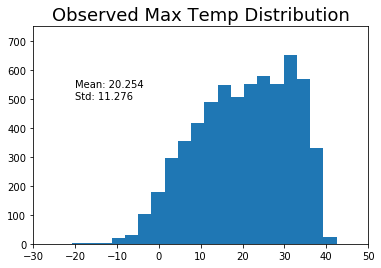

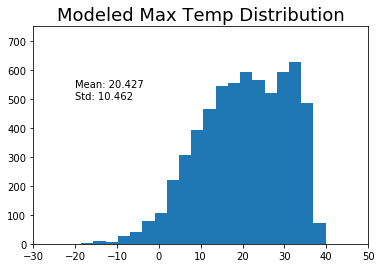

In [27]:
def plotDists(final_preds):
    """Plotting the true and modeled distributions on a log scale"""
    for data, title in zip([Y_test.tmax, final_preds], ['Observed', 'Modeled']):
        length = data.shape[0] #number of pts
        pmean = round(float(data.mean()),3) #mean
        pstd = round(float(data.std()),3) #standard deviation

        #plot details
        plt.hist(data, bins = 20)
        plt.title(title + ' Max Temp Distribution',fontsize=18) #title
        plt.xlim(xmin=-30, xmax = 50)
        plt.ylim(ymin=0, ymax = 750)

        #show mean and std
        plt.text(-20,500, "Mean: " + str(pmean) + "\nStd: " + str(pstd))
        plt.show()
        
plotDists(final_preds)

## Adding a normal distribution element

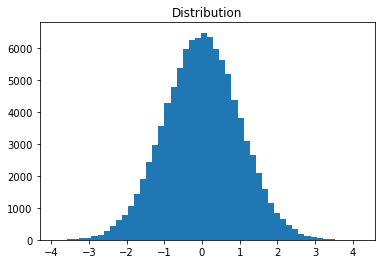

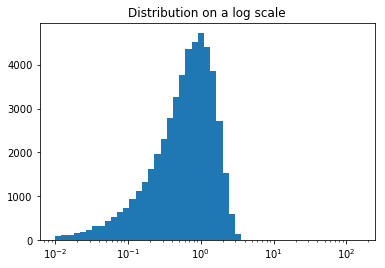

In [26]:
mu, sigma = 0, 1 #mean and standard deviation
data = np.random.normal(mu, sigma, 100000) #gettign 100,000 random points from this distribution

def makePlots(data):
    """Plotting a distibution on a normal scale and on a log scale."""
    
    #plotting a normal distribution
    plt.hist(data, bins = 50)
    plt.title('Distribution')
    plt.show()

    #plotting the same distribution on a log scale
    ax = plt.subplot()
    ax.set_xscale("log", nonposx='clip')
    logbins = np.geomspace(0.01,150, 50)
    plt.hist(data, bins=logbins)
    plt.title('Distribution on a log scale')
    plt.show()
    
makePlots(data)

## Gamma Distributions 

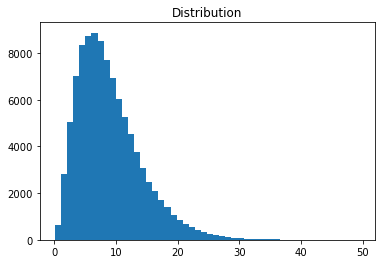

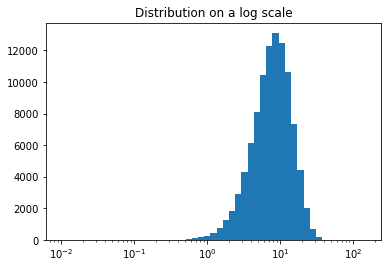

In [110]:
k = 3 #shape
theta = 3 #scale

makePlots(np.random.gamma(k,theta,100000))

## Adding a stochastic element to the predictions

You can change the distributions to see what works the best

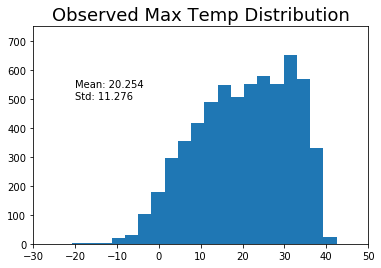

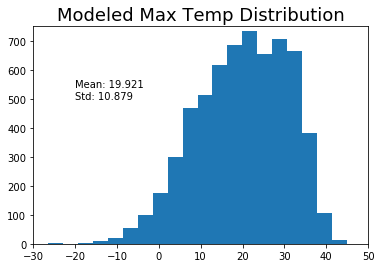

In [31]:
#Normal 
mu, sigma =-0.5, 3

#Gamma
k, theta = 2,5

np.random.seed(42)

#toggle these two lines to do a normal or gamma distribution
stochast = np.random.normal(mu, sigma, final_preds.shape[0])
#stochast = np.random.gamma(k,theta,final_preds.shape[0])

corrected_preds = final_preds + stochast

plotDists(corrected_preds)

### Write the final predictions to disk

In [34]:
#save location
location = '/glade/work/kwheelan/datasets'

#just saving as a txt file right now, but I could convert to xarray if needed
#saves just the predicted precip values in order of data
np.savetxt(os.path.join(location, 'oddYrPreds_TMAX_' + str(lat) + '.' + str(lon) + '.txt'), corrected_preds, delimiter = ',')